In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from myImageLib import wowcolor
import numpy as np
import os
from corrLib import *
from corr_utils import *
from scipy.signal import savgol_filter
import typesetting.main as tm
from scipy.integrate import trapz
tm.prl('1-column-2-panel')
dirs = data_log_mapping(kw='aug')
from log import experiment_log

In [52]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'E:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
dirs = data_log_mapping(kw='aug') # video info for GNF raw data, obtained from Aug 3rd to Aug 6th
log_df = experiment_log()
n0_to_vf = 0.12 # n0 to volume fraction

-------The log looks OK!--------


### Investigate the kinks in energy spectra at high $k$

- hypothesis 1: it originates from the PIV box size.
- test: change PIV box size, see if the location of the kink changes
- The kinks in energy spectra always happen at twice of the step size corresponding wavenumber. In order to have valid data in range (7, 42) for fitting, as the giant number fluctuations, I need to target step size below 3.5 um, which corresponds to 10 px in length. 

In [44]:
# boxsize = 50; step = 25
summary = pd.read_csv(os.path.join(r'E:\moreData\08032020\energy_spectrum_varstep', r'summary.csv')).set_index('k')
data = pd.DataFrame()
for s in summary['sample'].drop_duplicates():
    subdata = summary.loc[summary['sample']==s]   
    x, y = xy_bin(subdata.index, subdata.E, bins=np.logspace(-3, -0.3, 100))
    x = x * 2 * np.pi
    y *= 2 * np.pi * x    
    name = int(s.split('=')[1])
    temp = pd.DataFrame({'x': x, name: y}).set_index('x')
    data = pd.concat((data, temp))

data = data[[5, 10, 15, 20]]

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


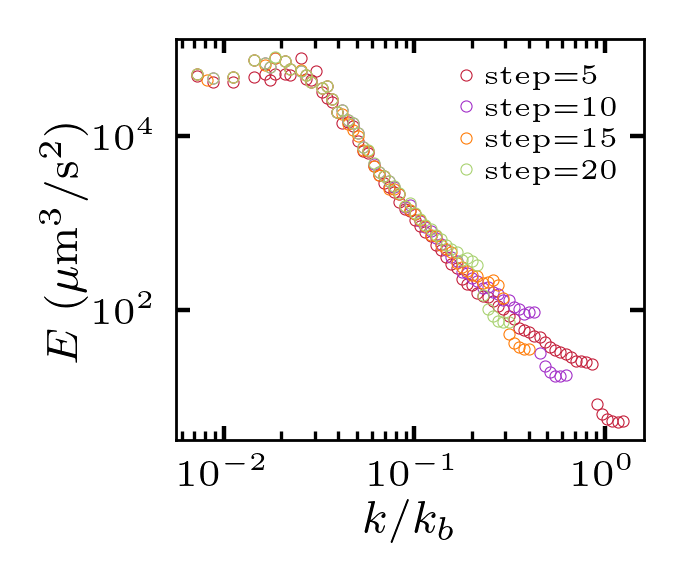

In [54]:
fig, ax = plt.subplots()
count = 0
for kw in data:
    ax.plot(data.index/ 2 / np.pi * 3, data[kw]*kw * kw/4/np.pi**2/2, 
             ls='', marker='o', markersize=2, mec=wowcolor(count),
            mew=0.2, mfc=(0,0,0,0), label='step={:d}'.format(kw))
    count += 1
ax.loglog()
ax.legend(fontsize=5)
ax.set_xlabel('$k/k_b$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.tight_layout()
fig.savefig(os.path.join(data_master_dir, 
                         r'Research projects\DF\Figures\technical-details\kinks-in-energy-spectra\kins.pdf'))

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

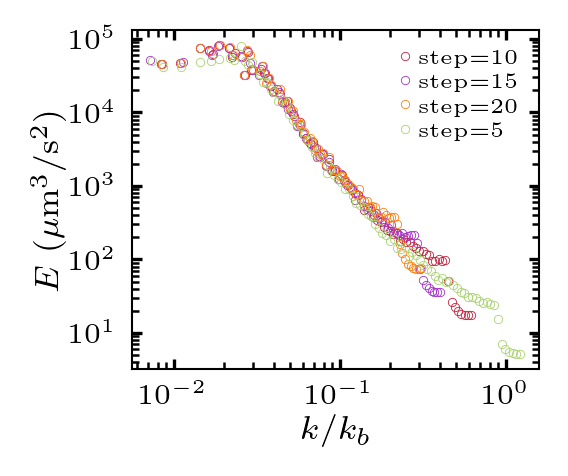

In [9]:
plt.figure(dpi=300)
count = 0
for s in summary['sample'].drop_duplicates():
    subdata = summary.loc[summary['sample']==s]
    x, y = xy_bin(subdata.index, subdata.E)
    x = x * 2 * np.pi
    y *= 2 * np.pi * x
    step = int(s.split('=')[1])
    plt.plot(x / 2 / np.pi * 3, y*step*step/4/np.pi**2/2, 
             ls='', marker='o', markersize=2, mec=wowcolor(count),
           mew=0.2, mfc=(0,0,0,0), label=s)
    count += 1
plt.legend(fontsize=5)
plt.loglog()
plt.xlabel('$k/k_b$')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')

<font color='green'>**Conclusion:** the kind indeed originates from the size of PIV step size. As I change the step size, the location of kink also changes. I checked the PIV results at various step sizes (5, 10, 15, 20, 25 px) at fixed box size (50 px), and they show no difference. Note that in the plot above, I scaled the y value of all the four curves with step$^2$, because the built-in FFT of velocity is just a sum of weighted velocity and is not the desired velocity density (per wavenumber). The unit of this Fourier Transform $A_k$ is clearly the same as $a_m$. In order to get unit [velocity] * [length], and to make transform result consistent at different data density,I introduce sample_spacing $d$ as a modifier of the DFT. After this modification, the energy spectrum computed at various step size (of PIV) should give quantitatively similar results.

### Test new energy spectrum normalization scheme

- The modified energy_spectrum() function fixed the bug where results for same data, different step sizes are different. Here we test how the new function works.

In [2]:
pivData15 = pd.read_csv(r'E:\moreData\08032020\piv_varstep\step=15\00\3000-3001.csv')
pivData25 = pd.read_csv(r'E:\moreData\08032020\piv_imseq\00\3000-3001.csv')

In [3]:
es15 = energy_spectrum(pivData15)
es25 = energy_spectrum(pivData25)

E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


[]

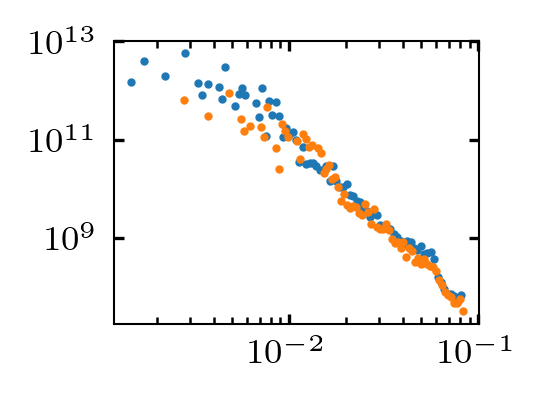

In [8]:
plt.figure(dpi=300)
x, y = log_bin(es15.k, es15.E)
plt.plot(x, y, ls='', marker='o', markersize=1)
x, y = log_bin(es25.k, es25.E)
plt.plot(x, y, ls='', marker='o', markersize=1)
plt.loglog()

<font color='red'> **Question:** what is the unit of energy spectrum? If it's 2-D spectrum, the unit should be [length]$^4$/[time]$^2$. What if we integrate in a small shell to make it 1-D spectrum? Would this modify the unit?